# Part 2: House Prices Classification 

Understanding the factors that influence housing prices is key in real estate analytics, urban planning, and financial decision-making. In this project, we analyze a comprehensive dataset of residential home sales from Ames, Iowa (Dean De Cock), which is widely used as a benchmark in predictive modeling.
 
In part 2, we build a classification model by converting `SalePrice` into price categories (e.g., low / mid / high). We then apply a machine learning approach using classifiers.

We follow the following workflow:
1. Load and inspect data
2. Clean + preprocess (handle missing values, encode categories)
3. Train models (Logistic Regression and Random Forest)
4. Evaluate using accuracy + confusion matrix + classification report
5. Fit best model and predict test labels
6. Create figures (confusion matrix + feature importance)

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [51]:
train_df = pd.read_csv("../Part1-EDA/kaggledata/clean_train.csv")
test_df  = pd.read_csv("../Part1-EDA/kaggledata/test.csv")

The SalePrice variable is continuous, so we convert it into discrete price classes. Here, we use three classes: low (0), medium (1), and high prices (2).

In [52]:
def make_price_classes(sale_price, n_bins=3):
    # equal-sized groups
    y = pd.qcut(sale_price, q=n_bins, labels=False, duplicates="drop").astype(int)

    bins = pd.qcut(sale_price, q=n_bins, duplicates="drop").cat.categories
    label_map = {i: f"{bins[i].left:.0f}–{bins[i].right:.0f}" for i in range(len(bins))}
    
    class_names = [f"class {i} ({label_map[i]})" for i in range(len(label_map))]
    return y, label_map, class_names

y, label_map, class_names = make_price_classes(train_df["SalePrice"], n_bins=3)

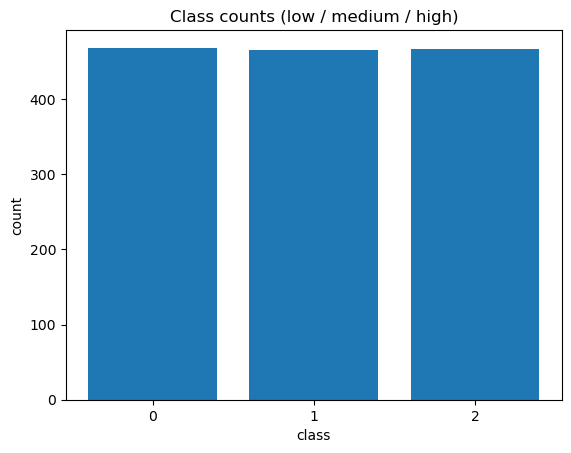

<Figure size 640x480 with 0 Axes>

In [25]:
# plot distribution counts - do we have balance
counts = pd.Series(y).value_counts().sort_index()

plt.figure()
plt.bar(range(len(counts)), counts.values)
plt.xticks(range(len(counts)), [f"{i}" for i in counts.index])
plt.title("Class counts (low / medium / high)")
plt.xlabel("class")
plt.ylabel("count")
plt.show()

plt.savefig("Graphs/class_distribution_counts.png", bbox_inches="tight")

The class distribution appears to be balanced across low, medium, and high price categories, i.e. the classification task is well-suited for training and evaluation.

In [77]:
# split features 
x = train_df.drop(columns=["SalePrice"]).copy()
test_x = test_df.copy()

# any columns with missing values?
print("total missing in x:", int(x.isna().sum().sum()))
print("total missing in test_x:", int(test_x.isna().sum().sum()))

total missing in x: 7310
total missing in test_x: 7878


In [78]:
# split missingness into numeric vs categorical columns
na_num = x[num_cols].isna().sum()
na_num = na_num[na_num > 0].sort_values(ascending=False)

na_cat = x[cat_cols].isna().sum()
na_cat = na_cat[na_cat > 0].sort_values(ascending=False)

print("numeric columns with NaNs:")
display(na_num)

print("categorical columns with NaNs:")
display(na_cat)

numeric columns with NaNs:


GarageYrBlt    81
dtype: int64

categorical columns with NaNs:


PoolQC          1393
MiscFeature     1345
Alley           1308
Fence           1122
MasVnrType       861
FireplaceQu      689
GarageQual        81
GarageType        81
GarageFinish      81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
dtype: int64

The remaining NaN values appear in both categorical and numeric features. Since sklearn
models cannot run with NaNs, we can use two imputers: (1) categorical NaNs are filled with value "None", while numeric NaNs are filled with "0".

In [82]:
num_cols = x.select_dtypes(include=np.number).columns
cat_cols = x.select_dtypes(exclude=np.number).columns

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0))
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

In [83]:
# training data / validation data -- keep 20% of the data for validation and stratify by price class
x_train, x_valid, y_train, y_valid = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [84]:
# evaluate our models : logistic regression + random forest
def eval_model(name, pipe):
    pipe.fit(x_train, y_train)
    preds = pipe.predict(x_valid)

    acc = accuracy_score(y_valid, preds)
    cm = confusion_matrix(y_valid, preds)

    print("\n" + "="*70)
    print(name)
    print(f"accuracy: {acc:.3f}\n")
    print("classification report:\n")
    print(classification_report(y_valid, preds, target_names=class_names))

    return acc, cm


logistic_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=1,
        class_weight="balanced_subsample"
    ))
])

log_acc, log_cm = eval_model("logistic regression", logistic_pipe)
rf_acc,  rf_cm  = eval_model("random forest", rf_pipe)


logistic regression
accuracy: 0.761

classification report:

                         precision    recall  f1-score   support

 class 0 (34900–138000)       0.84      0.74      0.79        94
class 1 (138000–185000)       0.64      0.69      0.66        93
class 2 (185000–340000)       0.81      0.85      0.83        93

               accuracy                           0.76       280
              macro avg       0.77      0.76      0.76       280
           weighted avg       0.77      0.76      0.76       280


random forest
accuracy: 0.829

classification report:

                         precision    recall  f1-score   support

 class 0 (34900–138000)       0.84      0.83      0.83        94
class 1 (138000–185000)       0.74      0.75      0.74        93
class 2 (185000–340000)       0.91      0.90      0.91        93

               accuracy                           0.83       280
              macro avg       0.83      0.83      0.83       280
           weighted avg       0.

Random forest achieves higher validation accuracy than logistic regression, so we use it for predictions below.

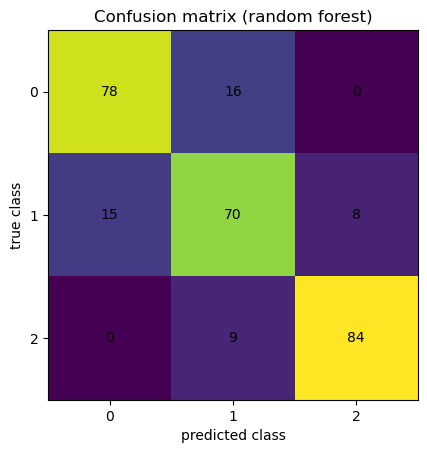

<Figure size 640x480 with 0 Axes>

In [86]:
plt.figure()
plt.imshow(rf_cm)
plt.title("Confusion matrix (random forest)")
plt.xlabel("predicted class")
plt.ylabel("true class")
plt.xticks(range(3), [0, 1, 2])
plt.yticks(range(3), [0, 1, 2])

for i in range(rf_cm.shape[0]):
    for j in range(rf_cm.shape[1]):
        plt.text(j, i, str(rf_cm[i, j]), ha="center", va="center")

plt.show()
plt.savefig("Graphs/confusion_matrix.png", bbox_inches="tight")

The confusion matrix compares true classes (i.e. the ground truth) to predicted classes and shows that most homes are classified correctly, with mistakes mainly between adjacent price groups.

In [58]:
# now fit random forest on full training df
rf_pipe.fit(x, y)
test_preds = rf_pipe.predict(test_x)

pred_df = pd.DataFrame({
    "Id": test_ids,
    "pred_class": test_preds,
    "pred_label": [label_map[i] for i in test_preds]
})

pred_df.head()

,Id,pred_class,pred_label
0,1461,0,34900–138000
1,1462,1,138000–185000
2,1463,1,138000–185000
3,1464,1,138000–185000
4,1465,2,185000–340000


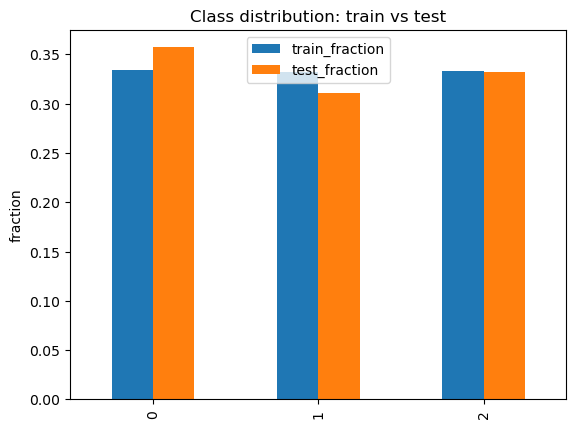

<Figure size 640x480 with 0 Axes>

In [62]:
# let's compare predicted classes to training distribution -- pretty close!
train_dist = pd.Series(y).value_counts(normalize=True).sort_index()
test_dist  = pred_df["pred_class"].value_counts(normalize=True).sort_index()

dist_df = pd.DataFrame({
    "train_fraction": train_dist,
    "test_fraction": test_dist
})

dist_df

dist_df.plot(kind="bar")
plt.ylabel("fraction")
plt.title("Class distribution: train vs test")
plt.show()

plt.savefig("Graphs/class_distribution_train_vs_test.png", bbox_inches="tight")

The predicted class distribution on the test set is reasonably balanced and consistent
with the training data, suggesting no obvious distribution shift in predictions. This is as expected.

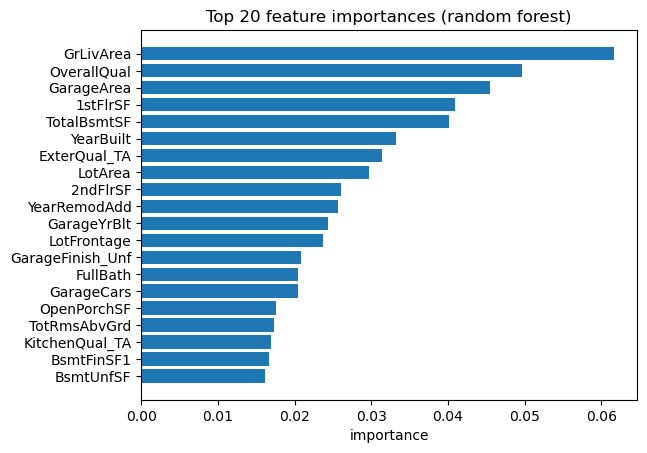

<Figure size 640x480 with 0 Axes>

In [63]:
rf_model = rf_pipe.named_steps["model"]

ohe = rf_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols.astype(str), cat_feature_names])

importances = rf_model.feature_importances_
top_k = 20
idx = np.argsort(importances)[::-1][:top_k]

plt.figure()
plt.barh(range(top_k), importances[idx][::-1])
plt.yticks(range(top_k), feature_names[idx][::-1])
plt.title("Top 20 feature importances (random forest)")
plt.xlabel("importance")
plt.show()

plt.savefig("Graphs/top_20_rf_features.png", bbox_inches="tight")

The most important features for predicting price category are higher-quality construction, larger living areas, better garage and basement characteristics, and how new the home is. 